In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Dataset: https://zenodo.org/record/7148117

In [2]:
df_loaded = pd.read_csv("go_arounds_augmented.csv")

/var/folders/_j/vd_r650147l_5pl4bwls0xg00000gn/T/ipykernel_44103/1259920069.py:1: DtypeWarning: Columns (4,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loaded = pd.read_csv("go_arounds_augmented.csv")


In [3]:
df = df_loaded.copy()

In [4]:
df.columns

Index(['time', 'icao24', 'callsign', 'airport', 'runway', 'has_ga',
       'n_approaches', 'n_rwy_approached', 'registration', 'typecode',
       'icaoaircrafttype', 'wtc', 'glide_slope_angle', 'has_intersection',
       'rwy_length', 'airport_country', 'airport_region', 'operator_country',
       'operator_region', 'wind_speed_knts', 'wind_dir_deg', 'wind_gust_knts',
       'visibility_m', 'temperature_deg', 'press_sea_level_p', 'press_p',
       'weather_intensity', 'weather_precipitation', 'weather_desc',
       'weather_obscuration', 'weather_other'],
      dtype='object')

# Decoding Weather Info

In [5]:
np.unique(df['weather_intensity'])

array(["['', '', '']", "['', '', 'VC']", "['', '']", "['', '+']",
       "['', '-', '']", "['', '-', '-']", "['', '-']", "['', 'VC', '']",
       "['', 'VC', 'VC']", "['', 'VC']", "['']", "['+', '', '']",
       "['+', '', 'VC']", "['+', '']", "['+', '-']", "['+', 'VC']",
       "['+']", "['-', '', '']", "['-', '', 'VC']", "['-', '']",
       "['-', '+']", "['-', '-', '']", "['-', '-']", "['-', 'VC', '']",
       "['-', 'VC', 'VC']", "['-', 'VC']", "['-']", "['VC', '', '']",
       "['VC', '']", "['VC', '+', '']", "['VC', '+']", "['VC', '-', '']",
       "['VC', '-', '-']", "['VC', '-']", "['VC', 'VC']", "['VC']", '[]'],
      dtype=object)

In [6]:
np.unique(df['weather_precipitation'])

array(["['BC', 'MI']", "['BC', 'SH']", "['BC', None]", "['BC']",
       "['BL', 'SH']", "['BL', None]", "['BL']", "['DR', 'SH']", "['DR']",
       "['FZ', 'FZ']", "['FZ', 'SH']", "['FZ', None, None]",
       "['FZ', None]", "['FZ']", "['FZBC', None]", "['FZBC']", "['FZPR']",
       "['MI', 'BC']", "['MI', None]", "['MI']", "['PR', 'BC', None]",
       "['PR', 'BC']", "['PR', 'FZ']", "['PR', 'MI']", "['PR', None]",
       "['PR']", "['SH', 'BC', None]", "['SH', 'BC']", "['SH', 'BL']",
       "['SH', 'DR']", "['SH', 'PR']", "['SH', 'SH']",
       "['SH', 'TS', None]", "['SH', 'TS']", "['SH', None]", "['SH']",
       "['TS', 'BC']", "['TS', 'BL']", "['TS', 'SH', None]",
       "['TS', 'SH']", "['TS', 'TS', 'SH']", "['TS', 'TS', None]",
       "['TS', 'TS']", "['TS', None, None]", "['TS', None]", "['TS']",
       "[None, 'BC', 'TS']", "[None, 'BC', None]", "[None, 'BC']",
       "[None, 'BL', 'FZ']", "[None, 'BL', None]", "[None, 'BL']",
       "[None, 'DR']", "[None, 'FZ', 'BL']", "[None,

In [7]:
import ast

intensities_map = {'-' : 2, '': 3, '+': 4, 'VC': 1}
weather_types = ['MI', 'PR', 'BC', 'DR', 'BL', 'SH', 'TS', 'FZ', 'DZ', 'RA', 'SN', 'SG', 'IC', 'PL', 'GR', 'GS', 'UP', 'BR', 'FG', 'FU', 'VA', 'DU', 'SA', 'HZ', 'PY', 'PO', 'SQ', 'FC', 'SS', 'DS']
multiple_precipitation_attributes = ['PLRA', 'RASN', 'SNRA', 'RAPL', 'RASNPL', 'SNPL', 'DZSN', 'PLSN', 'RAGR']

def encode_weather(df):
    for weather_type in weather_types:
        df[weather_type] = np.zeros(len(df))
    
    for weather_type in weather_types:
        df.loc[:, weather_type] = np.zeros(len(df))
    
    for index, row in df.iterrows():
        intensities = ast.literal_eval(row['weather_intensity'])
        for i in range(len(intensities)):
            for cat in ['weather_precipitation', 'weather_desc', 'weather_obscuration', 'weather_other']:
                attribute = ast.literal_eval(row[cat])[i]
                if attribute:
                    df.loc[index, attribute] = intensities_map[intensities[i]]
                    
    # Cleaning up codes with multiple precipitation attributes
    for weather_type in multiple_precipitation_attributes:
        col = df[weather_type].dropna()
        for i in range(0, len(weather_type), 2):
            attribute = weather_type[i : i + 2]
            for index in col.index:
                df.loc[index, attribute] = col[index]
                
    
    df.drop(multiple_precipitation_attributes, axis=1, inplace=True)

In [8]:
# Some records are missing, imputation infeasible :(
df = df.dropna()
encode_weather(df)
df

,time,icao24,callsign,airport,runway,has_ga,n_approaches,n_rwy_approached,registration,typecode,...,VA,DU,SA,HZ,PY,PO,SQ,FC,SS,DS
341,2019-01-06 18:50:59+00:00,ab7270,AAL750,KAUS,18L,False,1,1,N837AW,A319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
342,2019-01-06 18:53:45+00:00,abf8e0,SWA5180,KAUS,18L,False,1,1,N8701Q,B38M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,2019-01-06 18:54:58+00:00,a4c865,UAL422K,KAUS,18R,False,1,1,N407UA,A320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,2019-01-06 20:33:50+00:00,ab6eb9,AAL644,KAUS,18L,False,1,1,N836AW,A319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362,2019-01-06 20:41:54+00:00,abdc91,ASH6150,KAUS,18R,False,1,1,N86311,E75L,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8962323,2019-07-15 20:42:46+00:00,a5d007,ASA788,KMSY,11,False,1,1,N474AS,B739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8962333,2019-07-15 21:13:34+00:00,a81163,NKS6504,KMSY,11,False,1,1,N619NK,A320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8962492,2019-07-16 20:31:17+00:00,a7f762,NKS1070,KMSY,11,False,1,1,N612NK,A320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8962493,2019-07-16 20:35:50+00:00,a726fb,ASA788,KMSY,11,False,1,1,N560AS,B738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Engineering

One-hot encoding icao aircraft type (info here: https://skybrary.aero/articles/aircraft-description-icao-doc-8643). Converting wake turbulence category to a numerical feature. Higher values mean more turbulence.

In [9]:
df = df.join(pd.get_dummies(df['icaoaircrafttype']))
df['wtc'] = df['wtc'].map({'H': 3, 'M': 2, 'L/M' : 1.5, 'L' : 1})

In [10]:
import matplotlib.pyplot as plt


In [15]:
import re

diffs = []

rwy_series = df['runway'].astype(str)
for idx, val in df['runway'].astype(str).items():
    runway_dir = int(re.sub(r'[A-Z]', "", val)) * 10
    diff = runway_dir - df.loc[idx, 'wind_dir_deg']
    
    if diff < -180:
        diff += 360
    elif diff < 0:
        diff += 180
    elif diff > 180:
        diff -= 180
        
    diffs.append(diff)
    
df['runway_wind_angle'] = diffs

In [30]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X = df[[
 'glide_slope_angle',
 'has_intersection',
 'rwy_length',
 'wind_speed_knts',
 'wind_gust_knts',
 'visibility_m',
 'temperature_deg',
 'press_sea_level_p',
 'press_p',
 'wtc',
 'runway_wind_angle',
 'MI',
 'PR',
 'BC',
 'DR',
 'BL',
 'SH',
 'TS',
 'DZ',
 'RA',
 'SN',
 'SG',
 'IC',
 'PL',
 'GR',
 'GS',
 'UP',
 'BR',
 'FG',
 'FU',
 'VA',
 'DU',
 'SA',
 'HZ',
 'PY',
 'PO',
 'SQ',
 'FC',
 'SS',
 'DS',
 'H1P',
 'H1T',
 'H2T',
 'L1P',
 'L1T',
 'L2J',
 'L2P',
 'L2T',
 'L3J',
 'L4J',
 'L4T']]
y = df['has_ga']

sm = RandomOverSampler(random_state=21)
X_oversampled, y_oversampled = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=21)

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(n_estimators=100, estimator=base_estimator)
clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100)

In [32]:
clf.score(X_test, y_test)

0.6432111414241294

In [33]:
from sklearn.metrics import balanced_accuracy_score

y_pred = clf.predict(X_test)
balanced_accuracy_score(y_pred, y_test)

0.6501851311026956

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[63140, 20878],
       [39019, 44841]])

In [35]:
clf.feature_importances_

array([0.03, 0.01, 0.27, 0.02, 0.08, 0.04, 0.15, 0.17, 0.08, 0.01, 0.07,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.01, 0.  , 0.01, 0.  ])

In [36]:
X.columns

Index(['glide_slope_angle', 'has_intersection', 'rwy_length',
       'wind_speed_knts', 'wind_gust_knts', 'visibility_m', 'temperature_deg',
       'press_sea_level_p', 'press_p', 'wtc', 'runway_wind_angle', 'MI', 'PR',
       'BC', 'DR', 'BL', 'SH', 'TS', 'DZ', 'RA', 'SN', 'SG', 'IC', 'PL', 'GR',
       'GS', 'UP', 'BR', 'FG', 'FU', 'VA', 'DU', 'SA', 'HZ', 'PY', 'PO', 'SQ',
       'FC', 'SS', 'DS', 'H1P', 'H1T', 'H2T', 'L1P', 'L1T', 'L2J', 'L2P',
       'L2T', 'L3J', 'L4J', 'L4T'],
      dtype='object')

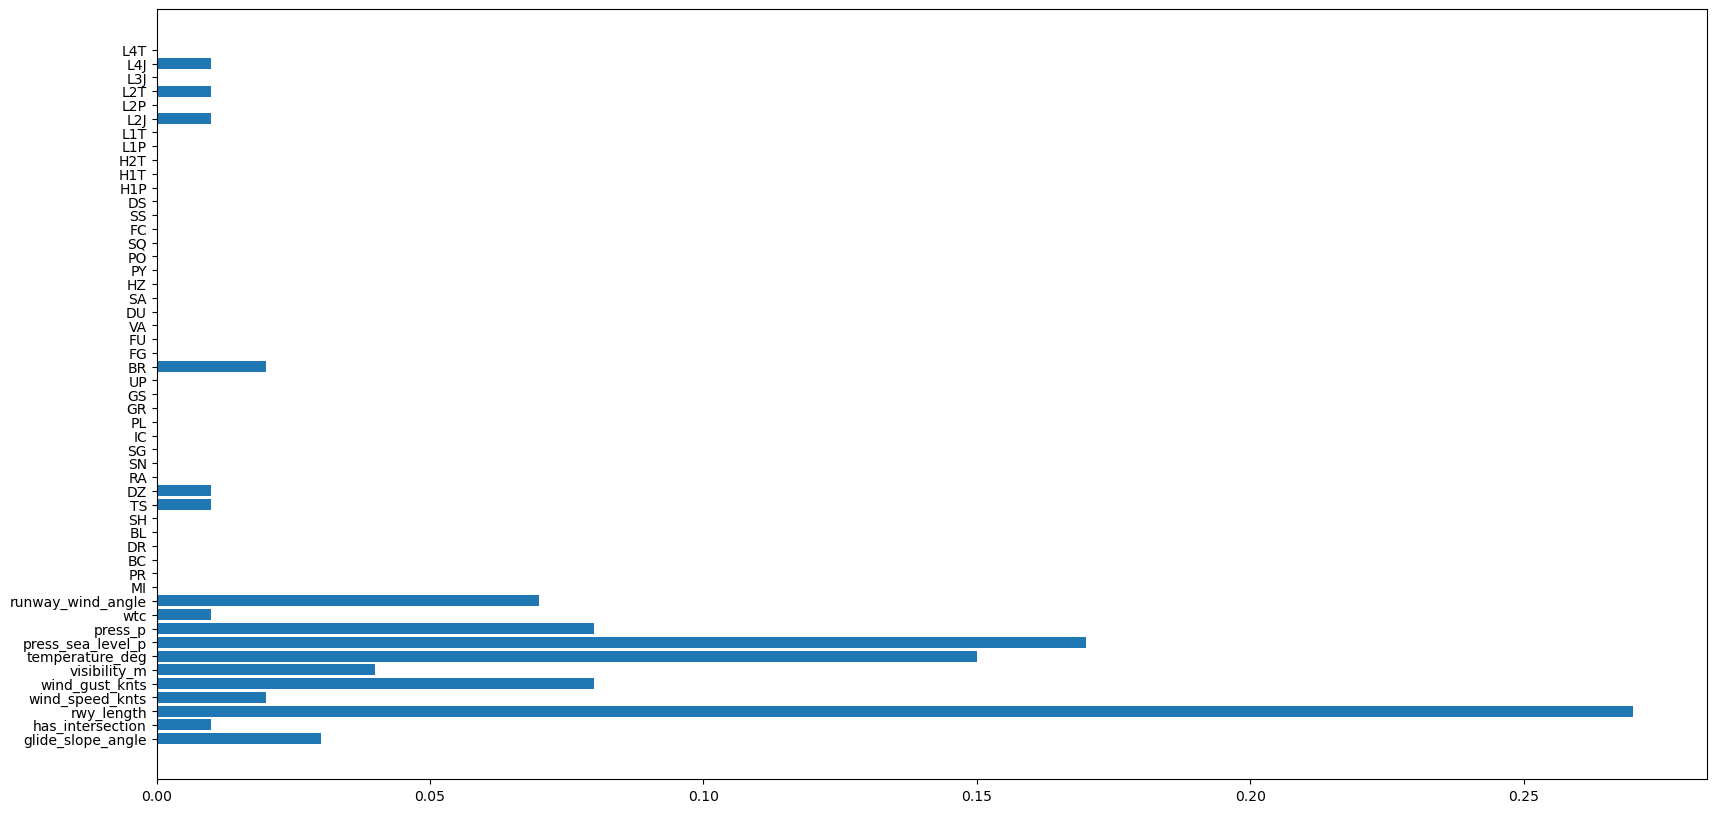

In [37]:
fig, ax = plt.subplots()
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_, label=X.columns)
ax.set_yticks(np.arange(len(clf.feature_importances_)), labels=X.columns, fontsize=10)
plt.rcParams["figure.figsize"] = (20,10);

In [161]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=21)
X_resampled, y_resampled = sampler.fit_resample(X, y)

scaler = StandardScaler()
X_centered = scaler.fit_transform(X_resampled)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_centered)

In [162]:
y

341        False
342        False
343        False
360        False
362        False
           ...  
8962323    False
8962333    False
8962492    False
8962493    False
8962498    False
Name: has_ga, Length: 421587, dtype: bool

In [163]:
X_reduced.shape

(5676, 2)

In [164]:
sum(y)

1892

In [165]:
X_reduced

array([[ 2.61228644, -0.73871062],
       [-0.13136209,  0.95833751],
       [ 2.59239539,  1.37539682],
       ...,
       [-0.22464352, -1.2257166 ],
       [-0.01237481, -1.47038571],
       [-0.44716013, -0.49080684]])

In [177]:
X[:NUM_PTS,1]

InvalidIndexError: (slice(None, 10000, None), 1)

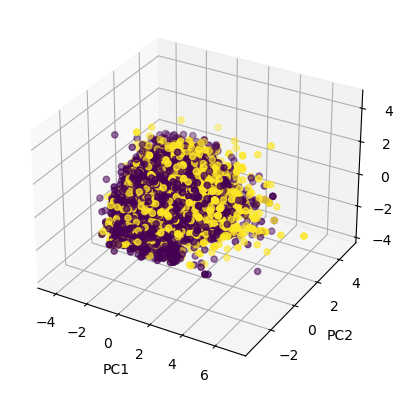

In [179]:
NUM_PTS = 10000

sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=21)
X_resampled, y_resampled = sampler.fit_resample(X, y)

scaler = StandardScaler()
X_centered = scaler.fit_transform(X_resampled)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_centered)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_reduced[:NUM_PTS,0], X_reduced[:NUM_PTS,1], X_reduced[:NUM_PTS,2], c=y_resampled[:NUM_PTS])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

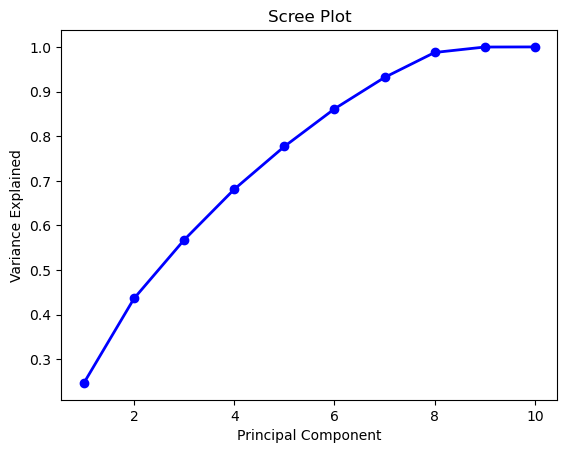

In [169]:
sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=21)
X_resampled, y_resampled = sampler.fit_resample(X, y)

scaler = StandardScaler()
X_centered = scaler.fit_transform(X_resampled)

pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X_centered)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()